## data exploration  grouping account with location to find out credit and debit habbit of        customersds
## locate client location in terms of state
## regression model
## 1)features needed for model 1) age ,2) gender 3) client location
## 2) model used is 1) decision tree and 2)xg boost
## 3) one hot encoding used on location of the client 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor

In [2]:
df1 = pd.read_excel('ANZ synthesised transaction dataset.xlsx')
pd.set_option('display.max_columns', None) 
df1.head(2)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit


In [3]:
df1.account=df1.account.str.extract('(\d+)')

## find out no missing data

In [4]:
total = df1.isnull().sum().sort_values(ascending=False)
percent = ((df1.isnull().sum()/len(df1))*100).sort_values(ascending=True)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
nan=missing_data[missing_data["Total"]>0].index
missing_data=missing_data[missing_data["Total"]>0]
nan=pd.DataFrame(nan, columns=['nan col'])
nan
j=[]
for i in nan['nan col']:
    j.append(df1[i].dtype)
j=pd.DataFrame(j,columns=['type'])
nan=pd.concat([nan,j],axis=1).set_index('nan col')
nan=pd.concat([missing_data,nan],axis=1)
nan

,Total,Percent,type
nan col,,,
merchant_code,11160,92.667940,float64
bpay_biller_code,11158,92.651333,object
card_present_flag,4326,35.921282,float64
merchant_state,4326,35.921282,object
merchant_suburb,4326,35.921282,object
merchant_id,4326,35.921282,object
merchant_long_lat,4326,35.921282,object


## use regular expression to clean customer id 

In [5]:
df1.customer_id=df1.customer_id.str.extract('(\d+)')
df1.account=df1.account.str.extract('(\d+)')
df1

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,2487424745,153.44 -28.06,debit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,authorized,0.0,NaN,3021093232,AUD,149.83 -29.47,POS,32aa73dc-b7c2-4161-b14d-6271b96ce792,NaN,Melissa,14054.14,2018-10-31,F,30,Ringwood,VIC,2018-10-31T23:09:06.000+0000,9.79,f2e3e695c2ee4c50a4c8747f852cbe2e,Australia,55310383,145.23 -37.81,debit
12039,authorized,1.0,NaN,1608363396,AUD,151.22 -33.87,SALES-POS,296a0500-8552-48ac-ac81-ec37065b568e,NaN,Robert,9137.79,2018-10-31,M,20,Casula,NSW,2018-10-31T23:21:46.000+0000,63.87,56e147e5485f4683b9076fcaaed76640,Australia,2688605418,150.88 -33.96,debit
12040,authorized,1.0,NaN,3827517394,AUD,151.12 -33.89,POS,e5975ab4-08f7-4725-a369-24cc0e35ed6e,NaN,Craig,45394.57,2018-10-31,M,28,Kings Park,NSW,2018-10-31T23:34:25.000+0000,43.96,2fdd4681827343f6af2e6519644a684a,Australia,2663907001,150.92 -33.74,debit
12041,authorized,1.0,NaN,2920611728,AUD,144.96 -37.76,SALES-POS,af49051a-591d-4b08-bd3c-27730b70ed37,NaN,Tyler,11350.67,2018-10-31,M,69,Oakleigh,VIC,2018-10-31T23:47:05.000+0000,30.77,74aa9cd7e4af4c6d9cd7dbd28e9aedc9,Australia,1388323263,145.09 -37.91,debit


## work location to find out client location state 

In [6]:
df1[['long','lat']]=df1['long_lat'].str.split("-",expand=True)
df1['lat']=df1['lat'].astype('float')
df1['long']=df1['long'].astype('float')
df1['lat']=df1['lat'].round().astype('int')
df1['long']=df1['long'].round().astype('int')
df1['long']

0        153
1        153
2        151
3        153
4        153
        ... 
12038    150
12039    151
12040    151
12041    145
12042    151
Name: long, Length: 12043, dtype: int32

In [7]:
df1['merchant_long_lat']=df1['merchant_long_lat'].fillna(0)
df1['merchant_long_lat'].isnull().sum()

0

In [8]:
df1['merchant_long_lat'].replace(np.nan, 0)
df1['merchant_long_lat'].dtype

dtype('O')

In [9]:
df1[['merchant_long','merchant_lat']]=df1['merchant_long_lat'].str.split("-",expand=True)
df1['merchant_lat']=df1['merchant_lat'].astype('float')
df1['merchant_long']=df1['merchant_long'].astype('float')
df1['merchant_lat']=df1['merchant_lat'].round()
df1['merchant_long']=df1['merchant_long'].round()

In [10]:

df1['merchant_long']=df1['merchant_long'].fillna(0)
df1['merchant_lat']=df1['merchant_lat'].fillna(0)
df1['merchant_lat'].isnull().sum()
df1['merchant_long']=df1['merchant_long'].astype('int')
df1['merchant_lat']=df1['merchant_lat'].astype('int')

In [11]:
df1

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,long,lat,merchant_long,merchant_lat
0,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,2487424745,153.38 -27.99,debit,153,28,153,28
1,authorized,0.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,2487424745,151.21 -33.87,debit,153,28,151,34
2,authorized,1.0,NaN,1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,2142601169,151.21 -33.87,debit,151,34,151,34
3,authorized,1.0,NaN,1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,1614226872,153.05 -26.68,debit,153,28,153,27
4,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,2487424745,153.44 -28.06,debit,153,28,153,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,authorized,0.0,NaN,3021093232,AUD,149.83 -29.47,POS,32aa73dc-b7c2-4161-b14d-6271b96ce792,NaN,Melissa,14054.14,2018-10-31,F,30,Ringwood,VIC,2018-10-31T23:09:06.000+0000,9.79,f2e3e695c2ee4c50a4c8747f852cbe2e,Australia,55310383,145.23 -37.81,debit,150,29,145,38
12039,authorized,1.0,NaN,1608363396,AUD,151.22 -33.87,SALES-POS,296a0500-8552-48ac-ac81-ec37065b568e,NaN,Robert,9137.79,2018-10-31,M,20,Casula,NSW,2018-10-31T23:21:46.000+0000,63.87,56e147e5485f4683b9076fcaaed76640,Australia,2688605418,150.88 -33.96,debit,151,34,151,34
12040,authorized,1.0,NaN,3827517394,AUD,151.12 -33.89,POS,e5975ab4-08f7-4725-a369-24cc0e35ed6e,NaN,Craig,45394.57,2018-10-31,M,28,Kings Park,NSW,2018-10-31T23:34:25.000+0000,43.96,2fdd4681827343f6af2e6519644a684a,Australia,2663907001,150.92 -33.74,debit,151,34,151,34
12041,authorized,1.0,NaN,2920611728,AUD,144.96 -37.76,SALES-POS,af49051a-591d-4b08-bd3c-27730b70ed37,NaN,Tyler,11350.67,2018-10-31,M,69,Oakleigh,VIC,2018-10-31T23:47:05.000+0000,30.77,74aa9cd7e4af4c6d9cd7dbd28e9aedc9,Australia,1388323263,145.09 -37.91,debit,145,38,145,38


In [12]:
#account,balance,amount,movement
sf=df1['account'].unique()
df2=df1[['account','balance','amount','movement','date','merchant_state','long','lat','merchant_long','merchant_lat']]
df2[df2['account']=='1598451071'][46:86]
df3=df2

In [13]:
df3=df3.sort_values(['account'],ascending=True)
df3['cus_loc'] = df3.long.astype(str).str.cat(df3.lat.astype(str))
df3['mer_loc'] = df3.merchant_long.astype(str).str.cat(df3.merchant_lat.astype(str))
#df3.drop(['long','lat','merchant_long','merchant_lat'],axis=1,inplace=True)
df3

,account,balance,amount,movement,date,merchant_state,long,lat,merchant_long,merchant_lat,cus_loc,mer_loc
7763,1037050564,3971.61,16.99,debit,2018-09-29,QLD,153,28,153,27,15328,15327
3140,1037050564,2318.79,6.88,debit,2018-08-25,QLD,153,28,153,27,15328,15327
11260,1037050564,5186.96,50.91,debit,2018-10-25,QLD,153,28,153,27,15328,15327
8895,1037050564,3700.94,35.62,debit,2018-10-07,VIC,153,28,145,38,15328,14538
8891,1037050564,3736.56,12.63,debit,2018-10-07,QLD,153,28,153,27,15328,15327
...,...,...,...,...,...,...,...,...,...,...,...,...
7722,966140392,8622.83,10.98,debit,2018-09-29,VIC,147,38,145,38,14738,14538
7720,966140392,8633.81,425.32,debit,2018-09-29,VIC,147,38,145,38,14738,14538
1513,966140392,2583.87,51.90,debit,2018-08-12,QLD,147,38,147,26,14738,14726
6364,966140392,6842.51,9.07,debit,2018-09-19,VIC,147,38,145,38,14738,14538


In [14]:
df3['cus_loc']=df3['cus_loc'].astype('int')
df3['mer_loc']=df3['mer_loc'].astype('int')

## client and merchant  location difference 0 or in range of 0 to 5 means that both client and merchant are in the same state . now the merchant state name for location difference= 0 can be taken as client location state. by replace using dictionary.

In [15]:
df3['diff']=df3['cus_loc']-df3['mer_loc']
df3

,account,balance,amount,movement,date,merchant_state,long,lat,merchant_long,merchant_lat,cus_loc,mer_loc,diff
7763,1037050564,3971.61,16.99,debit,2018-09-29,QLD,153,28,153,27,15328,15327,1
3140,1037050564,2318.79,6.88,debit,2018-08-25,QLD,153,28,153,27,15328,15327,1
11260,1037050564,5186.96,50.91,debit,2018-10-25,QLD,153,28,153,27,15328,15327,1
8895,1037050564,3700.94,35.62,debit,2018-10-07,VIC,153,28,145,38,15328,14538,790
8891,1037050564,3736.56,12.63,debit,2018-10-07,QLD,153,28,153,27,15328,15327,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7722,966140392,8622.83,10.98,debit,2018-09-29,VIC,147,38,145,38,14738,14538,200
7720,966140392,8633.81,425.32,debit,2018-09-29,VIC,147,38,145,38,14738,14538,200
1513,966140392,2583.87,51.90,debit,2018-08-12,QLD,147,38,147,26,14738,14726,12
6364,966140392,6842.51,9.07,debit,2018-09-19,VIC,147,38,145,38,14738,14538,200


## seperating data with cleint location difference =0

In [16]:
df4=df3[df3['diff']==0]
df4

,account,balance,amount,movement,date,merchant_state,long,lat,merchant_long,merchant_lat,cus_loc,mer_loc,diff
11253,1037050564,5237.87,40.96,debit,2018-10-25,QLD,153,28,153,28,15328,15328,0
6667,1037050564,3879.87,22.34,debit,2018-09-21,QLD,153,28,153,28,15328,15328,0
10397,1037050564,4912.07,13.88,debit,2018-10-19,QLD,153,28,153,28,15328,15328,0
8391,1037050564,4420.56,21.96,debit,2018-10-04,QLD,153,28,153,28,15328,15328,0
8800,1037050564,3791.95,43.62,debit,2018-10-07,QLD,153,28,153,28,15328,15328,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4852,958000567,7235.72,31.57,debit,2018-09-07,NT,131,12,131,12,13112,13112,0
114,964839203,27984.90,26.75,debit,2018-08-01,NSW,147,36,147,36,14736,14736,0
11515,964839203,42618.25,24.67,debit,2018-10-27,VIC,147,36,147,36,14736,14736,0
249,964839203,27884.42,14.47,debit,2018-08-02,VIC,147,36,147,36,14736,14736,0


In [17]:
g=df4.groupby(['account','balance','merchant_state']).mean()

g

amount  long  lat  merchant_long  \
account    balance  merchant_state                                     
1037050564 1097.80  QLD               7.66   153   28            153   
           1164.32  QLD              45.13   153   28            153   
           1209.45  QLD             145.72   153   28            153   
           1491.31  QLD              42.11   153   28            153   
           1533.42  QLD              36.03   153   28            153   
...                                    ...   ...  ...            ...   
958000567  12914.98 NT               13.84   131   12            131   
964839203  27884.42 VIC              14.47   147   36            147   
           27984.90 NSW              26.75   147   36            147   
           42487.02 NSW              18.59   147   36            147   
           42618.25 VIC              24.67   147   36            147   

                                    merchant_lat  cus_loc  mer_loc  diff  
account    balance  merchant_state                                        
1037050564 1097.80  QLD                       28    15328    15328     0  
           1164.32  QLD                       28    15328    15328     0  
           1209.45  QLD                       28    15328    15328     0  
           1491.31  QLD                       28    15328    15328     0  
           1533.42  QLD                       28    15328    15328     0  
...                                          ...      ...      ...   ...  
958000567  12914.98 NT                        12    13112    13112     0  
964839203  27884.42 VIC                       36    14736    14736     0  
           27984.90 NSW                       36    14736    14736     0  
           42487.02 NSW                       36    14736    14736     0  
           42618.25 VIC                       36    14736    14736     0  

[4604 rows x 8 columns]

In [18]:
acc=df4['account'].unique()
s2=[]
s1 = pd.DataFrame([])
for i in acc:
    s2=df4[df4['account']==i].mode()
    s1=s1.append(s2,ignore_index=True)
s1=s1.dropna(how='any')
s1=s1.sort_values(by='account',ascending=True)
s1=s1.reset_index()

    

In [19]:
sf=pd.DataFrame(sf,columns=['acc'])
sf.sort_values(by='acc',inplace=True,ascending=True)
sf

,acc
2,1037050564
50,1056639002
94,1199531521
65,1217063613
1,1222300524
...,...
56,854938045
59,90814749
44,958000567
60,964839203


In [20]:
dp=pd.concat([s1,sf],axis=1)
dp.tail(10)

,index,account,balance,amount,movement,date,merchant_state,long,lat,merchant_long,merchant_lat,cus_loc,mer_loc,diff,acc
90,3881.0,854938045,6677.87,18.59,debit,2018-08-05,QLD,148.0,23.0,148.0,23.0,14823.0,14823.0,0.0,1424176027
91,3888.0,90814749,5697.08,7.00,debit,2018-09-01,NSW,152.0,33.0,152.0,33.0,15233.0,15233.0,0.0,3317636250
92,3918.0,958000567,228.34,6.51,debit,2018-10-11,NT,131.0,12.0,131.0,12.0,13112.0,13112.0,0.0,3741880913
93,3994.0,964839203,27884.42,14.47,debit,2018-08-01,NSW,147.0,36.0,147.0,36.0,14736.0,14736.0,0.0,2265520058
94,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1199531521
95,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2528867619
96,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2650850707
97,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998563091
98,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3233697971
99,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240804743


In [21]:
#1199531521,2528867619,2650850707,1998563091,3233697971,240804743
x1=dp.copy()
del1=['2528867619','2650850707','1998563091','3233697971','240804743']

In [22]:
#delete_row = x1[x1["acc"]==1199531521]
delete_row=df1[df1['account']=='1199531521'].index
df1 = df1.drop(delete_row,axis=0)
delete_row=df1[df1['account']=='2528867619'].index
df1 = df1.drop(delete_row,axis=0)
delete_row=df1[df1['account']=='2650850707'].index
df1 = df1.drop(delete_row,axis=0)
delete_row=df1[df1['account']=='1998563091'].index
df1 = df1.drop(delete_row,axis=0)
delete_row=df1[df1['account']=='3233697971'].index
df1 = df1.drop(delete_row,axis=0)
delete_row=df1[df1['account']=='240804743'].index
df1 = df1.drop(delete_row,axis=0)

In [23]:
s1.drop('index',axis=1,inplace=True)

In [24]:
s1.drop(['balance','amount','movement','date','cus_loc','mer_loc','diff'],axis=1,inplace=True)


In [25]:
s1['account'].astype(str)
s1['merchant_state'].astype(str)

0     QLD
1     VIC
2      WA
3     NSW
4     NSW
     ... 
89     WA
90    QLD
91    NSW
92     NT
93    NSW
Name: merchant_state, Length: 94, dtype: object

## dictionary of account and state name

In [26]:
s1=s1.set_index('account')

In [27]:
d1=s1.to_dict('dict')

In [28]:

d1


{'merchant_state': {'1037050564': 'QLD',
  '1056639002': 'VIC',
  '1199531521': 'WA',
  '1222300524': 'NSW',
  '1243371644': 'NSW',
  '1279356312': 'VIC',
  '1334819143': 'VIC',
  '1344825761': 'NSW',
  '1349834573': 'VIC',
  '1424176027': 'NSW',
  '1438600314': 'SA',
  '1443681913': 'NSW',
  '1496451953': 'VIC',
  '1516130869': 'NT',
  '1523339231': 'WA',
  '154431271': 'QLD',
  '1598451071': 'QLD',
  '1608363396': 'NSW',
  '1650504218': 'VIC',
  '1652235822': 'VIC',
  '1683215619': 'SA',
  '1710017148': 'NSW',
  '1788473090': 'VIC',
  '1799207998': 'NSW',
  '182446574': 'WA',
  '1890605467': 'VIC',
  '1903037542': 'QLD',
  '1973887809': 'WA',
  '1990648130': 'WA',
  '1998563091': 'ACT',
  '2014856841': 'VIC',
  '2107684084': 'VIC',
  '211792489': 'SA',
  '2153562714': 'WA',
  '2173390920': 'VIC',
  '2231965366': 'VIC',
  '2249586092': 'WA',
  '2259139624': 'VIC',
  '2265520058': 'NSW',
  '2270192619': 'SA',
  '2305712452': 'SA',
  '240804743': 'WA',
  '2528867619': 'SA',
  '261503870

In [29]:
d2={'1037050564': 'QLD',
  '1056639002': 'VIC',
  '1199531521': 'WA',
  '1222300524': 'NSW',
  '1243371644': 'NSW',
  '1279356312': 'VIC',
  '1334819143': 'VIC',
  '1344825761': 'NSW',
  '1349834573': 'VIC',
  '1424176027': 'NSW',
  '1438600314': 'SA',
  '1443681913': 'NSW',
  '1496451953': 'VIC',
  '1516130869': 'NT',
  '1523339231': 'WA',
  '154431271': 'QLD',
  '1598451071': 'QLD',
  '1608363396': 'NSW',
  '1650504218': 'VIC',
  '1652235822': 'VIC',
  '1683215619': 'SA',
  '1710017148': 'NSW',
  '1788473090': 'VIC',
  '1799207998': 'NSW',
  '182446574': 'WA',
  '1890605467': 'VIC',
  '1903037542': 'QLD',
  '1973887809': 'WA',
  '1990648130': 'WA',
  '1998563091': 'ACT',
  '2014856841': 'VIC',
  '2107684084': 'VIC',
  '211792489': 'SA',
  '2153562714': 'WA',
  '2173390920': 'VIC',
  '2231965366': 'VIC',
  '2249586092': 'WA',
  '2259139624': 'VIC',
  '2265520058': 'NSW',
  '2270192619': 'SA',
  '2305712452': 'SA',
  '240804743': 'WA',
  '2528867619': 'SA',
  '2615038700': 'VIC',
  '2650850707': 'QLD',
  '2673069055': 'QLD',
  '2674800293': 'VIC',
  '2681137560': 'NSW',
  '2776252858': 'VIC',
  '2828321672': 'QLD',
  '2890243754': 'QLD',
  '2897221629': 'NSW',
  '2920611728': 'VIC',
  '2970114956': 'VIC',
  '2988263882': 'VIC',
  '3021093232': 'NSW',
  '3084464802': 'VIC',
  '3100725361': 'QLD',
  '3233697971': 'NSW',
  '3317636250': 'QLD',
  '3326339947': 'NSW',
  '3481401842': 'WA',
  '3485804958': 'SA',
  '3536132544': 'VIC',
  '354106658': 'NSW',
  '3541460373': 'VIC',
  '3689607373': 'WA',
  '3741880913': 'QLD',
  '37709441': 'QLD',
  '3771436525': 'VIC',
  '3827517394': 'NSW',
  '3879258709': 'VIC',
  '3881031190': 'QLD',
  '38923874': 'NSW',
  '3941181087': 'WA',
  '3954677887': 'WA',
  '4059612845': 'NT',
  '4065652575': 'WA',
  '4258502723': 'VIC',
  '4274272854': 'VIC',
  '4281711154': 'VIC',
  '53508546': 'NSW',
  '559365433': 'TAS',
  '574997646': 'NSW',
  '588564840': 'NSW',
  '602667573': 'NSW',
  '721712940': 'VIC',
  '80388494': 'VIC',
  '819621312': 'VIC',
  '847145727': 'WA',
  '854938045': 'QLD',
  '90814749': 'NSW',
  '958000567': 'NT',
  '964839203': 'NSW',
  '1217063613':'QLD',
   '2171593283':'QLD',
  '2901672282':'out_stn',
  '414431115':'VIC',
  '4163822186':'QLD',
  '966140392':'VIC'}

In [30]:


type(d2)

dict

In [31]:
df4.groupby(['account','merchant_state']).mean()

balance     amount  long  lat  merchant_long  \
account    merchant_state                                                      
1037050564 QLD              3383.583827  30.494691   153   28            153   
           VIC              4236.100000  17.240000   153   28            153   
1056639002 VIC             45774.737959  33.959388   145   38            145   
1199531521 WA               8929.127097  27.976129   116   32            116   
1222300524 NSW              1172.268933  38.866800   151   34            151   
...                                 ...        ...   ...  ...            ...   
854938045  QLD             11727.391429  35.700000   148   23            148   
90814749   NSW              9494.045000  36.109667   152   33            152   
958000567  NT               7051.043816  73.530526   131   12            131   
964839203  NSW             35235.960000  22.670000   147   36            147   
           VIC             35251.335000  19.570000   147   36            147   

                           merchant_lat  cus_loc  mer_loc  diff  
account    merchant_state                                        
1037050564 QLD                       28    15328    15328     0  
           VIC                       28    15328    15328     0  
1056639002 VIC                       38    14538    14538     0  
1199531521 WA                        32    11632    11632     0  
1222300524 NSW                       34    15134    15134     0  
...                                 ...      ...      ...   ...  
854938045  QLD                       23    14823    14823     0  
90814749   NSW                       33    15233    15233     0  
958000567  NT                        12    13112    13112     0  
964839203  NSW                       36    14736    14736     0  
           VIC                       36    14736    14736     0  

[99 rows x 9 columns]

In [32]:
df2.groupby(['account','movement']).mean()

balance       amount   long   lat  merchant_long  \
account    movement                                                          
1037050564 credit     3959.400000   892.090000  153.0  28.0       0.000000   
           debit      3298.238780    31.257195  153.0  28.0     135.219512   
1056639002 credit    49718.081667  3195.010000  145.0  38.0       0.000000   
           debit     46085.282750    45.394125  145.0  38.0     105.212500   
1199531521 credit    12414.007143  3785.780000  116.0  32.0       0.000000   
...                           ...          ...    ...   ...            ...   
958000567  debit      6722.353054    71.646587  131.0  12.0      90.101796   
964839203  credit    35972.709231  1560.200000  147.0  36.0       0.000000   
           debit     35797.667714    56.684381  147.0  36.0      95.685714   
966140392  credit     7125.392857  2572.910000  147.0  38.0       0.000000   
           debit      5736.826000    37.971241  147.0  38.0     112.089655   

                     merchant_lat  
account    movement                
1037050564 credit        0.000000  
           debit        25.410569  
1056639002 credit        0.000000  
           debit        27.450000  
1199531521 credit        0.000000  
...                           ...  
958000567  debit        11.281437  
964839203  credit        0.000000  
           debit        21.838095  
966140392  credit        0.000000  
           debit        29.103448  

[200 rows x 6 columns]

In [33]:
df1['loc']=df1['account']
df1.head(5)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,long,lat,merchant_long,merchant_lat,loc
0,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,2487424745,153.38 -27.99,debit,153,28,153,28,1598451071
1,authorized,0.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,2487424745,151.21 -33.87,debit,153,28,151,34,1598451071
2,authorized,1.0,NaN,1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,2142601169,151.21 -33.87,debit,151,34,151,34,1222300524
3,authorized,1.0,NaN,1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,1614226872,153.05 -26.68,debit,153,28,153,27,1037050564
4,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,2487424745,153.44 -28.06,debit,153,28,153,28,1598451071


In [34]:
df1.head(2)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,long,lat,merchant_long,merchant_lat,loc
0,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,2487424745,153.38 -27.99,debit,153,28,153,28,1598451071
1,authorized,0.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,2487424745,151.21 -33.87,debit,153,28,151,34,1598451071


In [35]:
df13=df1.copy()

## replace using dictionary to change account numbers with state name

In [36]:
df1 = df1.replace({'loc': d2})
 

In [37]:
df1.head(5)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,long,lat,merchant_long,merchant_lat,loc
0,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,2487424745,153.38 -27.99,debit,153,28,153,28,QLD
1,authorized,0.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,2487424745,151.21 -33.87,debit,153,28,151,34,QLD
2,authorized,1.0,NaN,1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,2142601169,151.21 -33.87,debit,151,34,151,34,NSW
3,authorized,1.0,NaN,1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,1614226872,153.05 -26.68,debit,153,28,153,27,QLD
4,authorized,1.0,NaN,1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,2487424745,153.44 -28.06,debit,153,28,153,28,QLD


In [38]:
credit=df1[df1['movement']=='credit']

In [39]:
credit

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,long,lat,merchant_long,merchant_lat,loc
50,posted,NaN,0,588564840,AUD,151.27 -33.76,PAY/SALARY,NaN,0.0,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,1462656821,0,credit,151,34,0,0,NSW
61,posted,NaN,0,1650504218,AUD,145.01 -37.93,PAY/SALARY,NaN,0.0,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,2500783281,0,credit,145,38,0,0,VIC
64,posted,NaN,0,3326339947,AUD,151.18 -33.80,PAY/SALARY,NaN,0.0,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,326006476,0,credit,151,34,0,0,NSW
68,posted,NaN,0,3541460373,AUD,145.00 -37.83,PAY/SALARY,NaN,0.0,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,1433879684,0,credit,145,38,0,0,VIC
70,posted,NaN,0,2776252858,AUD,144.95 -37.76,PAY/SALARY,NaN,0.0,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,4123612273,0,credit,145,38,0,0,VIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,posted,NaN,0,1973887809,AUD,115.78 -31.90,PAY/SALARY,NaN,0.0,Antonio,9378.51,2018-10-31,M,26,NaN,NaN,2018-10-31T16:00:00.000+0000,1098.91,0e6cffb4401043c891ab7a50ec594208,Australia,1646621553,0,credit,116,32,0,0,WA
12000,posted,NaN,0,819621312,AUD,145.04 -37.85,PAY/SALARY,NaN,0.0,Michele,3440.01,2018-10-31,F,30,NaN,NaN,2018-10-31T17:00:00.000+0000,1158.15,ad13e06fffba4771b3c994f9147e68c0,Australia,1271030853,0,credit,145,38,0,0,VIC
12001,posted,NaN,0,2920611728,AUD,144.96 -37.76,PAY/SALARY,NaN,0.0,Tyler,11381.44,2018-10-31,M,69,NaN,NaN,2018-10-31T17:00:00.000+0000,1043.12,14a1604e6ead4b54b65d7a28ec546a69,Australia,1388323263,0,credit,145,38,0,0,VIC
12003,posted,NaN,0,1799207998,AUD,150.68 -33.79,PAY/SALARY,NaN,0.0,Susan,11454.52,2018-10-31,F,20,NaN,NaN,2018-10-31T17:00:00.000+0000,1395.49,cd1b1dea1d2f43e882d3499b3717d23b,Australia,164374203,0,credit,151,34,0,0,NSW


In [40]:
ge=pd.get_dummies(credit.gender)
ge

,F,M
50,0,1
61,1,0
64,0,1
68,0,1
70,1,0
...,...,...
11995,0,1
12000,1,0
12001,0,1
12003,1,0


In [41]:
ge.drop(['M'],axis=1,inplace=True)
credit=pd.concat([credit,ge],axis=1)

In [42]:
ge1=pd.get_dummies(credit['loc'])
#ge1.drop(['NSW'],axis=1,inplace=True)

In [43]:
credit=pd.concat([credit,ge1],axis=1)

In [44]:
credit.drop(['loc'],axis=1,inplace=True)
credit

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,long,lat,merchant_long,merchant_lat,F,NSW,NT,QLD,SA,TAS,VIC,WA,out_stn
50,posted,NaN,0,588564840,AUD,151.27 -33.76,PAY/SALARY,NaN,0.0,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,1462656821,0,credit,151,34,0,0,0,1,0,0,0,0,0,0,0
61,posted,NaN,0,1650504218,AUD,145.01 -37.93,PAY/SALARY,NaN,0.0,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,2500783281,0,credit,145,38,0,0,1,0,0,0,0,0,1,0,0
64,posted,NaN,0,3326339947,AUD,151.18 -33.80,PAY/SALARY,NaN,0.0,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,326006476,0,credit,151,34,0,0,0,1,0,0,0,0,0,0,0
68,posted,NaN,0,3541460373,AUD,145.00 -37.83,PAY/SALARY,NaN,0.0,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,1433879684,0,credit,145,38,0,0,0,0,0,0,0,0,1,0,0
70,posted,NaN,0,2776252858,AUD,144.95 -37.76,PAY/SALARY,NaN,0.0,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,4123612273,0,credit,145,38,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,posted,NaN,0,1973887809,AUD,115.78 -31.90,PAY/SALARY,NaN,0.0,Antonio,9378.51,2018-10-31,M,26,NaN,NaN,2018-10-31T16:00:00.000+0000,1098.91,0e6cffb4401043c891ab7a50ec594208,Australia,1646621553,0,credit,116,32,0,0,0,0,0,0,0,0,0,1,0
12000,posted,NaN,0,819621312,AUD,145.04 -37.85,PAY/SALARY,NaN,0.0,Michele,3440.01,2018-10-31,F,30,NaN,NaN,2018-10-31T17:00:00.000+0000,1158.15,ad13e06fffba4771b3c994f9147e68c0,Australia,1271030853,0,credit,145,38,0,0,1,0,0,0,0,0,1,0,0
12001,posted,NaN,0,2920611728,AUD,144.96 -37.76,PAY/SALARY,NaN,0.0,Tyler,11381.44,2018-10-31,M,69,NaN,NaN,2018-10-31T17:00:00.000+0000,1043.12,14a1604e6ead4b54b65d7a28ec546a69,Australia,1388323263,0,credit,145,38,0,0,0,0,0,0,0,0,1,0,0
12003,posted,NaN,0,1799207998,AUD,150.68 -33.79,PAY/SALARY,NaN,0.0,Susan,11454.52,2018-10-31,F,20,NaN,NaN,2018-10-31T17:00:00.000+0000,1395.49,cd1b1dea1d2f43e882d3499b3717d23b,Australia,164374203,0,credit,151,34,0,0,1,1,0,0,0,0,0,0,0


## seperating dependent and independent variables

In [45]:
y=credit['amount']
x=credit[['age','F','NT','QLD','SA','TAS','VIC','WA','out_stn']]
y

50       3903.95
61       1626.48
64        983.36
68       1408.08
70       1068.04
          ...   
11995    1098.91
12000    1158.15
12001    1043.12
12003    1395.49
12004    2639.76
Name: amount, Length: 830, dtype: float64

##  XGboost and decision tree models 

In [46]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [47]:
params = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'gamma': [0, 0.5, 1],
    'n_estimators': [50,100,150,200],
    'learning_rate': [0.5, 0.75, 1], 
}

In [48]:
xgf=XGBRegressor()

In [49]:
gxgf=GridSearchCV(xgf, params)

In [50]:
gxgf

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid

## train test split

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size = 50,
                                                    random_state = 2)

In [52]:
gxgf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid

In [53]:
predicted=gxgf.predict(X_test)

## RMSE value

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_test, predicted))
rms

505.65446680297225

## decision tree 

In [55]:
regressor = DecisionTreeRegressor(random_state = 0)

In [56]:
regressor.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [57]:
y_pred=regressor.predict(X_test)

In [58]:
rms = sqrt(mean_squared_error(y_test, y_pred))
rms

505.65716430489675

# end of regression model 

## start of exploratory data analysis (this was done before regression model,but due to time constraints i am not able to put it in correct order)

In [59]:
df_final=df1[['account','loc','balance','movement','amount']]

In [60]:
df_credit=df_final[df_final['movement']=='credit']
df_credit.groupby(['loc','movement']).mean()
#new_df = df_credit.groupby(['loc','movement']).mean().to_frame('amount').reset_index()
credit = pd.DataFrame(df_credit.groupby(['loc','movement']).mean()).reset_index()
credit

,loc,movement,balance,amount
0,NSW,credit,12670.559853,1891.109461
1,NT,credit,23389.203333,2823.873333
2,QLD,credit,7127.814338,1769.725000
3,SA,credit,8698.880000,1897.141111
4,TAS,credit,2807.029231,576.000000
5,VIC,credit,24355.731884,1790.756541
6,WA,credit,11974.108839,1907.930446
7,out_stn,credit,8446.091429,3328.770000


In [61]:
#average transaction
tra=df_final[df_final['movement']=='debit']
tra.groupby(['account','loc']).mean()

,,balance,amount
account,loc,,
1037050564,QLD,3298.238780,31.257195
1056639002,VIC,46085.282750,45.394125
1217063613,QLD,4306.916957,40.238261
1222300524,NSW,1165.981724,36.788828
1243371644,NSW,3903.305405,62.199459
...,...,...,...
854938045,QLD,11188.645494,54.017222
90814749,NSW,9456.808390,59.040508
958000567,NT,6722.353054,71.646587


In [62]:
debit=df_final[df_final['movement']=='debit']
df_credit.groupby(['loc','movement']).mean()
#new_df = df_credit.groupby(['loc','movement']).mean().to_frame('amount').reset_index()
debit = pd.DataFrame(debit.groupby(['loc','movement']).mean()).reset_index()
debit

,loc,movement,balance,amount
0,NSW,debit,11722.513249,56.924185
1,NT,debit,8621.022795,75.713372
2,QLD,debit,5842.555368,42.611563
3,SA,debit,11792.090046,44.576513
4,TAS,debit,2858.395200,41.325600
5,VIC,debit,25368.573068,55.564485
6,WA,debit,11298.013255,47.174086
7,out_stn,debit,5602.425517,84.347931


In [63]:
d=df_final.groupby(['loc','movement']).mean()
d

balance       amount
loc     movement                           
NSW     credit    12670.559853  1891.109461
        debit     11722.513249    56.924185
NT      credit    23389.203333  2823.873333
        debit      8621.022795    75.713372
QLD     credit     7127.814338  1769.725000
        debit      5842.555368    42.611563
SA      credit     8698.880000  1897.141111
        debit     11792.090046    44.576513
TAS     credit     2807.029231   576.000000
        debit      2858.395200    41.325600
VIC     credit    24355.731884  1790.756541
        debit     25368.573068    55.564485
WA      credit    11974.108839  1907.930446
        debit     11298.013255    47.174086
out_stn credit     8446.091429  3328.770000
        debit      5602.425517    84.347931

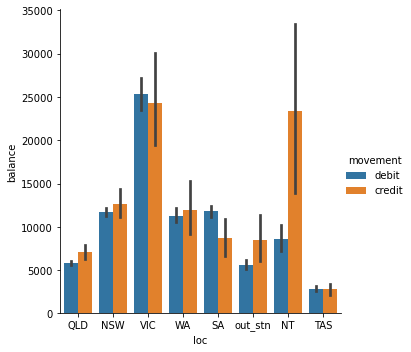

In [64]:
sns.catplot(x="loc", y="balance",hue = "movement", kind="bar", data=df_final);

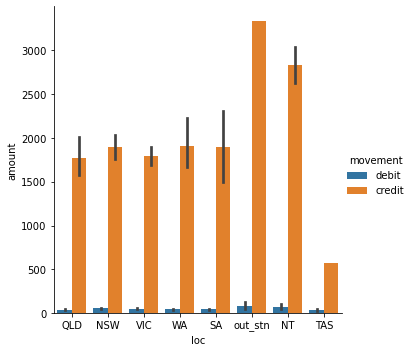

In [65]:
sns.catplot(x="loc", y="amount",hue = "movement", kind="bar", data=df_final);

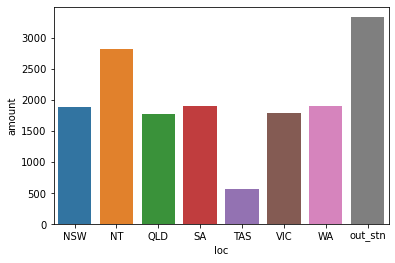

In [66]:
sns.barplot(x="loc", y="amount",data=credit);

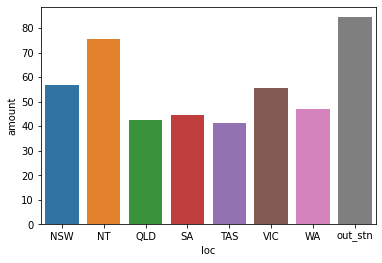

In [67]:
sns.barplot(x="loc", y="amount",data=debit);

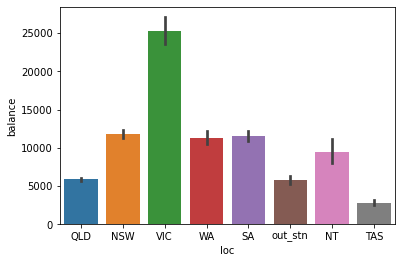

In [68]:
sns.barplot(x="loc", y="balance",data=df_final);

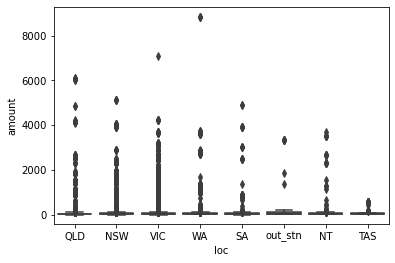

In [69]:
sns.boxplot(x='loc', y='amount',data=df_final)